# Understand and Optimizing Plan Giving Mailing Strategy

## Objective: 
* To understand what factors contributed most to convert regular donors to plan giving donors.
* To perform EDA to find any meaningful patterns of convertion.
* To create a model that predicts the likelihood if a certain donor will leave bequest.
* To create or improve different mailing strategies on targeted donors. 

The implementation of this model will allow non-profit to create better decision-making actions.

## We'll be covering:
 * Descriptive Analytics - what happened? 
 * Predictive Analytics - What might happen?
 * Prescriptive Analytics  - What should we do?  

## Dataset Variables:  

* Length - Donor's lifetime = (Deceased date/To date - First gift date)
* Age - Donor's Age
* Lapsed Time (in month) - Calculate the date difference between last gift date and current date.
* PG donors - Search all transactions and label the donor as PG donor if he/she donated to any plan giving campaigns (newsletter, PG card and etc..)
* Avg Giving circle (in month )- Donation frequency. 
* Appeal Desciption - Appeal description for donor's first gift
* Total Amount of Gift - Total gift amount before donors become plan giving donors.

## Imports Packages

In [76]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
import numpy as np
from pdpbox import pdp,info_plots
from sklearn.metrics import auc, roc_curve, classification_report
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
%matplotlib inline

In [77]:
DM_gift=pd.read_excel("DM_Gift_final Output.xlsx")
LFJ_deceased=pd.read_excel("lfj Decreased_Final _output.xlsx")
LFJ_living=pd.read_excel("LFJ_Living_final out.xlsx")

In [78]:
DM_gift.head()

,Constituent ID,Name,First Name,Last Name,Age,Total Amount of Gifts,Gift Amount,Gift Date,Appeal Description,avg giving circle month,lapsed time,length,PG donor,Convert
0,1,The Jacob Blaustein Institute,NaN,NaN,NaN,0.0,0.0,2017-02-14,Monthly,0,18,18,0,0
1,100000,John Templeton Foundation,NaN,NaN,NaN,5700000.0,200000.0,2012-09-20,DM,4,51,71,0,0
2,1000005,Irene Diamond Fund,NaN,NaN,NaN,1080000.0,100000.0,2012-10-04,DM,2,68,70,0,0
3,100001,Louise Filius,Louise,Filius,NaN,132.0,132.0,2010-07-18,online,0,97,97,0,0
4,1000012,Barry Kemp,Barry,Kemp,68.0,8500.0,2500.0,2013-10-10,event,11,36,58,0,0


In [79]:
LFJ_deceased.head()

,Constituent ID,Name,First Name,Last Name,Age,Total Amount of Gifts,Gift Amount,Gift Date,Appeal Description,Deceased Date,avg giving circle month,length,lapsed time,PG donor,Convert
0,1000016,Donald Pels,Donald,Pels,87.0,21417424.71,25000.0,1993-07-07,Staff Solicited,2014-10-16 00:00:00,8.0,255.0,4.0,0,1
1,1000045,Roland Algrant,Roland,Algrant,NaN,79150.00,5000.0,1989-12-01,event,2010-12-19 00:00:00,7.0,252.0,107.0,0,1
2,1000104,Cissy Patterson,Cissy,Patterson,NaN,45000.00,15000.0,1987-08-01,Staff Solicited,NaN,13.0,NaN,107.0,0,1
3,1000376,Leah Ice,Leah,Ice,NaN,15000.00,1000.0,1995-08-08,Unsolicited Donation,NaN,12.0,NaN,45.0,0,1
4,1001008,Joyce Reed Rosenberg,Joyce,Reed Rosenberg,NaN,7350.00,50.0,1992-04-29,Unsolicited Donation,2011-12-15 00:00:00,17.0,235.0,32.0,0,1


In [80]:
LFJ_living.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 14 columns):
Constituent ID             254 non-null int64
Name                       254 non-null object
First Name                 254 non-null object
Last Name                  254 non-null object
Age                        246 non-null float64
Total Amount of Gifts      254 non-null float64
Gift Amount                254 non-null float64
Gift Date                  254 non-null datetime64[ns]
Appeal Description         254 non-null object
avg giving circle month    240 non-null float64
lapsed time                254 non-null int64
length                     254 non-null int64
PG donor                   254 non-null int64
Convert                    254 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(5), object(4)
memory usage: 27.9+ KB


## Data Quality Check

In [81]:
DM_gift.isnull().any()

Constituent ID             False
Name                       False
First Name                  True
Last Name                   True
Age                         True
Total Amount of Gifts      False
Gift Amount                False
Gift Date                  False
Appeal Description         False
avg giving circle month    False
lapsed time                False
length                     False
PG donor                   False
Convert                    False
dtype: bool

In [82]:
LFJ_living.isnull().any()

Constituent ID             False
Name                       False
First Name                 False
Last Name                  False
Age                         True
Total Amount of Gifts      False
Gift Amount                False
Gift Date                  False
Appeal Description         False
avg giving circle month     True
lapsed time                False
length                     False
PG donor                   False
Convert                    False
dtype: bool

In [83]:
LFJ_deceased.isnull().any()

Constituent ID             False
Name                       False
First Name                 False
Last Name                  False
Age                         True
Total Amount of Gifts      False
Gift Amount                False
Gift Date                  False
Appeal Description         False
Deceased Date               True
avg giving circle month     True
length                      True
lapsed time                 True
PG donor                   False
Convert                    False
dtype: bool

In [84]:
# Remove 1 time DM donor
DM_gift=DM_gift[DM_gift['avg giving circle month']!=0]

In [85]:
#Display the statistical overview of living bequest donors
LFJ_living.describe()

,Constituent ID,Age,Total Amount of Gifts,Gift Amount,avg giving circle month,lapsed time,length,PG donor,Convert
count,2.540000e+02,246.000000,2.540000e+02,254.000000,240.000000,254.000000,254.000000,254.000000,254.0
mean,3.328792e+05,72.626016,7.184804e+06,3284.715433,10.883333,35.708661,142.145669,0.078740,1.0
std,4.397280e+05,12.425056,8.766777e+07,24509.244703,12.381105,23.655669,105.153673,0.269865,0.0
min,1.540000e+03,25.000000,0.000000e+00,0.000000,1.000000,1.000000,5.000000,0.000000,1.0
25%,5.815450e+04,67.000000,3.012500e+02,30.000000,4.000000,18.000000,82.250000,0.000000,1.0
50%,1.178525e+05,73.000000,8.900000e+02,50.000000,8.500000,32.000000,137.500000,0.000000,1.0
75%,1.989210e+05,81.000000,4.476250e+03,100.000000,13.000000,50.000000,183.750000,0.000000,1.0
max,1.349416e+06,98.000000,1.385764e+09,300000.000000,136.000000,133.000000,1300.000000,1.000000,1.0


In [86]:
#Display the statistical overview of deceased bequest donors
LFJ_deceased.describe()

,Constituent ID,Age,Total Amount of Gifts,Gift Amount,avg giving circle month,length,lapsed time,PG donor,Convert
count,1.190000e+02,41.000000,1.190000e+02,119.000000,110.000000,54.000000,100.000000,119.000000,119.0
mean,6.454338e+05,81.634146,2.019089e+05,634.493445,14.354545,149.740741,42.640000,0.016807,1.0
std,5.199095e+05,9.205314,1.965858e+06,2843.140811,14.337726,75.999301,40.731821,0.129090,0.0
min,3.247000e+03,59.000000,1.000000e+01,5.000000,1.000000,13.000000,2.000000,0.000000,1.0
25%,5.864050e+04,76.000000,2.600000e+02,25.000000,8.000000,96.500000,15.000000,0.000000,1.0
50%,1.001999e+06,82.000000,5.800000e+02,50.000000,11.000000,147.000000,31.500000,0.000000,1.0
75%,1.024868e+06,88.000000,2.624530e+03,100.000000,15.750000,190.750000,50.000000,0.000000,1.0
max,1.361742e+06,98.000000,2.141742e+07,25000.000000,108.000000,333.000000,257.000000,1.000000,1.0


In [87]:
DM_gift.describe()

,Constituent ID,Age,Total Amount of Gifts,Gift Amount,avg giving circle month,lapsed time,length,PG donor,Convert
count,7.505200e+04,59818.000000,7.505200e+04,7.505200e+04,75052.000000,75052.000000,75052.000000,75052.000000,75052.0
mean,2.384349e+05,71.920375,1.646320e+05,1.510849e+03,14.613122,33.879524,84.308386,0.024050,0.0
std,9.409478e+05,14.660757,1.201533e+07,6.251447e+04,14.063458,33.448722,37.496101,0.153205,0.0
min,2.000000e+00,1.000000,0.000000e+00,0.000000e+00,1.000000,0.000000,1.000000,0.000000,0.0
25%,6.635600e+04,64.000000,1.000000e+02,2.500000e+01,7.000000,8.000000,51.000000,0.000000,0.0
50%,1.160175e+05,73.000000,2.350000e+02,5.000000e+01,12.000000,20.000000,94.000000,0.000000,0.0
75%,1.743235e+05,82.000000,6.750000e+02,1.000000e+02,17.000000,56.000000,118.000000,0.000000,0.0
max,2.393136e+08,116.000000,2.371200e+09,1.000000e+07,126.000000,126.000000,127.000000,1.000000,0.0


In [88]:
LFJ_living[LFJ_living['length']>300]

,Constituent ID,Name,First Name,Last Name,Age,Total Amount of Gifts,Gift Amount,Gift Date,Appeal Description,avg giving circle month,lapsed time,length,PG donor,Convert
1,1002302,Michael A. Replogle,Michael,Replogle,64.0,1510.00,50.00,1988-02-12,DM,14.0,59,366,0,1
2,1004065,Kathleen Hanold,Kathleen,Hanold,89.0,425.00,15.00,1989-01-13,DM,36.0,64,355,0,1
3,1004379,Maile N. Johnson,Maile,Johnson,68.0,715.00,15.00,1990-07-18,DM,14.0,56,337,0,1
4,1005044,Miriam Berkley,Miriam,Berkley,74.0,560.00,20.00,1990-12-12,DM,22.0,14,332,0,1
5,1006922,Edward Eitches,Edward,Eitches,69.0,239.00,20.00,1991-12-20,DM,30.0,17,320,0,1
6,1007116,Fay Clayton,Fay,Clayton,71.0,216520.00,120.00,1991-12-31,DM,7.0,35,320,0,1
7,1007154,Cheryl Greenberg,Cheryl,Greenberg,60.0,1415.00,20.00,1991-12-31,DM,13.0,44,320,0,1
8,1007226,Shoshana Rihn,Shoshana,Rihn,87.0,11800.00,20.00,1991-12-31,DM,19.0,8,320,1,1
9,1008401,Judith Wechsler,Judith,Wechsler,77.0,1375.00,20.00,1992-08-07,DM,9.0,19,312,0,1
11,1009475,Leonard Sussman,Leonard,Sussman,71.0,4145.00,120.00,1993-06-07,DM,20.0,33,302,0,1


In [89]:
#remove the length =3000 donor
LFJ_living=LFJ_living[LFJ_living['length']<500]

In [90]:
LFJ_living.describe()

,Constituent ID,Age,Total Amount of Gifts,Gift Amount,avg giving circle month,lapsed time,length,PG donor,Convert
count,2.530000e+02,245.000000,2.530000e+02,253.000000,239.000000,253.000000,253.000000,253.000000,253.0
mean,3.301465e+05,72.644898,7.213200e+06,3297.303241,10.359833,35.581028,137.569170,0.079051,1.0
std,4.384333e+05,12.446954,8.784037e+07,24557.003309,9.374795,23.614764,75.895972,0.270354,0.0
min,1.540000e+03,25.000000,0.000000e+00,0.000000,1.000000,1.000000,5.000000,0.000000,1.0
25%,5.806400e+04,67.000000,3.000000e+02,30.000000,4.000000,18.000000,82.000000,0.000000,1.0
50%,1.174040e+05,73.000000,8.900000e+02,50.000000,8.000000,32.000000,135.000000,0.000000,1.0
75%,1.971990e+05,81.000000,4.500000e+03,100.000000,13.000000,50.000000,183.000000,0.000000,1.0
max,1.349416e+06,98.000000,1.385764e+09,300000.000000,81.000000,133.000000,366.000000,1.000000,1.0


In [91]:
LFJ_deceased.isnull().any()

Constituent ID             False
Name                       False
First Name                 False
Last Name                  False
Age                         True
Total Amount of Gifts      False
Gift Amount                False
Gift Date                  False
Appeal Description         False
Deceased Date               True
avg giving circle month     True
length                      True
lapsed time                 True
PG donor                   False
Convert                    False
dtype: bool

In [92]:
LFJ_living.isnull().any()

Constituent ID             False
Name                       False
First Name                 False
Last Name                  False
Age                         True
Total Amount of Gifts      False
Gift Amount                False
Gift Date                  False
Appeal Description         False
avg giving circle month     True
lapsed time                False
length                     False
PG donor                   False
Convert                    False
dtype: bool

## Inputing missing values

There are many appoaches to handle missing values: 
* Simply remove missing values. 
* Replace with group means.
* Build machine learning models to predict missing values. 
* Apply algorithems that rebust to outliers and missing values such as Random Forest and Logistic Regression.

We use group means to replace the missing value here. 

In [93]:
imr_deceased_Age = Imputer(missing_values=np.nan,strategy='mean')
imr_deceased_Age = imr_deceased_Age.fit(LFJ_deceased['Age'].values.reshape(-1,1))
LFJ_deceased['Imr_Age']= imr_deceased_Age.transform(LFJ_deceased['Age'].values.reshape(-1,1))

imr_deceased_length = Imputer(missing_values=np.nan,strategy='mean')
imr_deceased_length = imr_deceased_length.fit(LFJ_deceased['length'].values.reshape(-1,1))
LFJ_deceased['Imr_length']= imr_deceased_length.transform(LFJ_deceased['length'].values.reshape(-1,1))

imr_deceased_AvgGiving = Imputer(missing_values=np.nan,strategy='mean')
imr_deceased_AvgGiving = imr_deceased_AvgGiving.fit(LFJ_deceased['avg giving circle month'].values.reshape(-1,1))
LFJ_deceased['Imr_AvgGiving']= imr_deceased_AvgGiving.transform(LFJ_deceased['avg giving circle month'].values.reshape(-1,1))

imr_deceased_lapsed = Imputer(missing_values=np.nan,strategy='mean')
imr_deceased_lapsed = imr_deceased_AvgGiving.fit(LFJ_deceased['lapsed time'].values.reshape(-1,1))
LFJ_deceased['lapsed time']= imr_deceased_AvgGiving.transform(LFJ_deceased['lapsed time'].values.reshape(-1,1))

In [94]:
imr_living = Imputer(missing_values=np.nan,strategy='mean')
imr_living = imr_living.fit(LFJ_living['Age'].values.reshape(-1,1))
LFJ_living['Imr_Age']= imr_living.transform(LFJ_living['Age'].values.reshape(-1,1))

imr_living_AvgGiving = Imputer(missing_values=np.nan,strategy='mean')
imr_living_AvgGiving = imr_living_AvgGiving.fit(LFJ_living['avg giving circle month'].values.reshape(-1,1))
LFJ_living['Imr_AvgGiving']= imr_living_AvgGiving.transform(LFJ_living['avg giving circle month'].values.reshape(-1,1))

In [95]:
imr_DM = Imputer(missing_values=np.nan,strategy='mean')
imr_DM = imr_DM.fit(DM_gift['Age'].values.reshape(-1,1))
DM_gift['Imr_Age']= imr_DM.transform(DM_gift['Age'].values.reshape(-1,1))

In [96]:
###Remove records from Age less than 10
DM_gift[DM_gift['Age']<10]
DM_gift=DM_gift[DM_gift['Age']>10]

## Combine Three Datasets

In [97]:
DM_gift_v2=DM_gift[['Constituent ID','Imr_Age','Total Amount of Gifts','Appeal Description','avg giving circle month',
                    'lapsed time','length','PG donor','Convert']]
LFJ_deceased_v2=LFJ_deceased[['Constituent ID','Imr_Age','Total Amount of Gifts','Appeal Description','Imr_AvgGiving',
                    'lapsed time','Imr_length','PG donor','Convert']]
LFJ_living_v2=LFJ_living[['Constituent ID','Imr_Age','Total Amount of Gifts','Appeal Description','Imr_AvgGiving',
                    'lapsed time','length','PG donor','Convert']]
LFJ_deceased_v2=LFJ_deceased_v2.rename(columns={"Imr_AvgGiving":"avg giving circle month","Imr_length":"length"})
LFJ_living_v2=LFJ_living_v2.rename(columns={"Imr_AvgGiving":"avg giving circle month"})

In [98]:
frame=[DM_gift_v2,LFJ_deceased_v2,LFJ_living_v2]
df=pd.concat(frame)

In [99]:
df['Imr_Age']=df['Imr_Age'].astype(float)
df['avg giving circle month']=df['avg giving circle month'].astype(float)

## Exploratory Data Analysis

In [100]:
# How many donors are in the dataset? 
df.shape

(60189, 9)

In [101]:
# Calculate the convert rate of HRW's dataset. What is the rate of convertion?
df.Convert.value_counts(1)

0    0.993819
1    0.006181
Name: Convert, dtype: float64

In [102]:
# Display the statistical overview of the donors
df.describe()

,Constituent ID,Imr_Age,Total Amount of Gifts,avg giving circle month,lapsed time,length,PG donor,Convert
count,6.018900e+04,60189.000000,6.018900e+04,60189.000000,60189.000000,60189.000000,60189.000000,60189.000000
mean,2.514129e+05,71.943804,1.274008e+05,15.169968,32.500709,87.937732,0.028909,0.006181
std,1.042820e+06,14.642470,1.213661e+07,14.187141,32.535095,36.672219,0.167552,0.078374
min,1.700000e+01,20.000000,0.000000e+00,1.000000,0.000000,3.000000,0.000000,0.000000
25%,6.002700e+04,64.000000,9.500000e+01,8.000000,8.000000,56.000000,0.000000,0.000000
50%,1.102140e+05,73.000000,2.100000e+02,12.000000,20.000000,101.000000,0.000000,0.000000
75%,1.736460e+05,82.000000,5.500000e+02,17.000000,53.000000,119.000000,0.000000,0.000000
max,2.393136e+08,116.000000,2.371200e+09,126.000000,257.000000,366.000000,1.000000,1.000000


In [103]:
###Display the mean summary of Donors (Converted vs Non-Converted)
convert_summary=df.groupby('Convert')
convert_summary.mean()

,Constituent ID,Imr_Age,Total Amount of Gifts,avg giving circle month,lapsed time,length,PG donor
Convert,,,,,,,
0,250296.073156,71.921561,9.728274e+04,15.191935,32.467509,87.604861,0.028721
1,431004.537634,75.520491,4.970341e+06,11.637711,37.839140,141.462764,0.059140


Comparing with regular donor group, bequest group donors have higher lapsed time and Age, total gift amount, life time length and lapsed time. Also, the bequest group donors have less average giving circle which means bequest donors donated more frequently than regular donors. 




## Correlation Matrix

,Constituent ID,Imr_Age,Total Amount of Gifts,avg giving circle month,lapsed time,length,PG donor,Convert
Constituent ID,1.000000,0.021894,0.003481,-0.004206,-0.005833,0.051987,0.016724,0.013581
Imr_Age,0.021894,1.000000,-0.003024,-0.000309,0.098975,0.171177,0.070654,0.019263
Total Amount of Gifts,0.003481,-0.003024,1.000000,-0.006062,-0.006500,0.012071,-0.001795,0.031468
avg giving circle month,-0.004206,-0.000309,-0.006062,1.000000,-0.029268,0.201073,-0.041586,-0.019635
lapsed time,-0.005833,0.098975,-0.006500,-0.029268,1.000000,0.398177,-0.041972,0.012940
length,0.051987,0.171177,0.012071,0.201073,0.398177,1.000000,0.109816,0.115102
PG donor,0.016724,0.070654,-0.001795,-0.041586,-0.041972,0.109816,1.000000,0.014229
Convert,0.013581,0.019263,0.031468,-0.019635,0.012940,0.115102,0.014229,1.000000


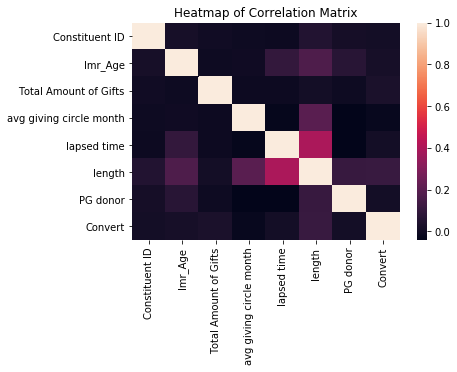

In [104]:
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Heatmap of Correlation Matrix')
corr

There is no significant correlation amoung all the numerical variables. 

## Pre-Processing

In [105]:
df['Convert']=df['Convert'].astype(int)
df['PG donor']=df['PG donor'].astype(object)

In [106]:
df.dtypes

Constituent ID               int64
Imr_Age                    float64
Total Amount of Gifts      float64
Appeal Description          object
avg giving circle month    float64
lapsed time                float64
length                     float64
PG donor                    object
Convert                      int32
dtype: object

## EDA One --Exploratory Data Analysis for All Donors

Text(0,0.5,'Donor count')

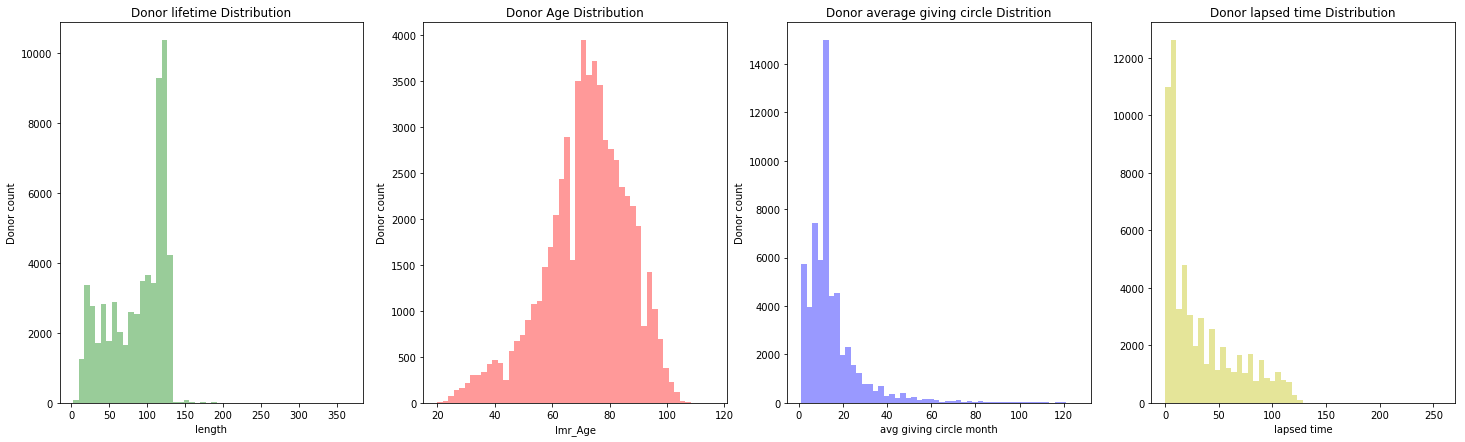

In [107]:
# Plot the distribution of donor lifetime, Age, and avg giving circle. What story can we tell?

# Set up the matplotlib figure
f, axes = plt.subplots(ncols=4,figsize=(25, 7))
# Graph Donor liftime (in month) Distribution
sns.distplot(df['length'], kde=False, color="g", ax=axes[0]).set_title('Donor lifetime Distribution')
axes[0].set_ylabel('Donor count')

# Graph Donor Age Distribution
sns.distplot(df['Imr_Age'], kde=False, color="r", ax=axes[1]).set_title('Donor Age Distribution')
axes[1].set_ylabel('Donor count')

# Graph Donor Total Gift Amount Distribution
sns.distplot(df['avg giving circle month'], kde=False, color="b", ax=axes[2]).set_title('Donor average giving circle Distrition')
axes[2].set_ylabel('Donor count')

# Graph Donor Avg Lapsed time 
sns.distplot(df['lapsed time'], kde=False, color="y", ax=axes[3]).set_title('Donor lapsed time Distribution')
axes[0].set_ylabel('Donor count')

* Donor Lifetime Distribution - Most of HRW donors fall into 110-140 month and a few donors donated more than 30 Yrs ago. 
 
* Donor Age Distribution - The majority of donors are older than 60 and most of them are within 60 - 80.
 
* Donor Average giving circle Distribution - About 6000 donors donated to HRW in every 2 months, and 4000 donors donated to HRW every 4 months. Most of donors donated to HRW in every 16 months. 
 
* Donor Lapsed time  - We can see some really lapsed donors in the file, but most of donors are active. 


## EDA 2  - Comparison bettwen Converted and Non Converted Donors

In [136]:
converted=df[df['Convert']==1]

converted_appeal = pd.DataFrame(converted['Appeal Description'].value_counts()).reset_index()
total_converted = pd.DataFrame(DM_gift_v2['Appeal Description'].value_counts()).reset_index()

converted_merge = pd.merge(converted_appeal,total_converted,how='inner',on='index')
converted_merge = converted_merge.rename(columns={"Appeal Description_x": "Converted",
                                                  "Appeal Description_y": "Non_Converted",
                                                 "index": "Appeal Description"})

converted_merge

,Appeal Description,Converted,Non_Converted
0,DM,248,47556
1,event,39,2874
2,online,29,5351
3,Unsolicited Donation,25,3311
4,Staff Solicited,14,443
5,PG(Campaign),1,269


Most of bequest donors were acquired by DM

Text(0.5,1,'Donor life time length Distribution - Converted V.S. Non Converted')

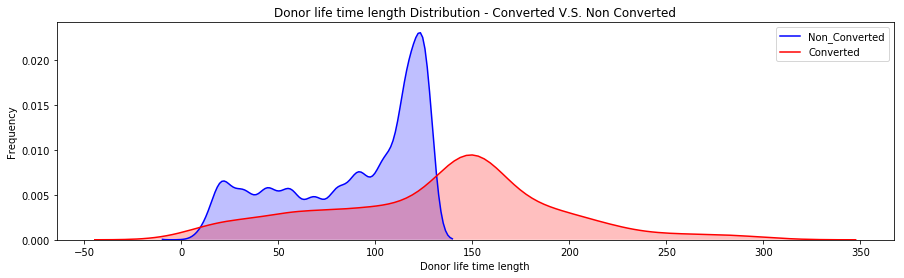

In [137]:
#KDEPlot: Kernel Density Estimate Plot#KDEPlot 
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(df.loc[(df['Convert'] == 0),'length'] , color='b',shade=True, label='Non_Converted')
ax=sns.kdeplot(df.loc[(df['Convert'] == 1),'length'] , color='r',shade=True, label='Converted')
ax.set(xlabel='Donor life time length', ylabel='Frequency')
plt.title('Donor life time length Distribution - Converted V.S. Non Converted')

Text(0.5,1,'Donor Avg Giving Circle Month Distribution - Converted V.S. Non Converted')

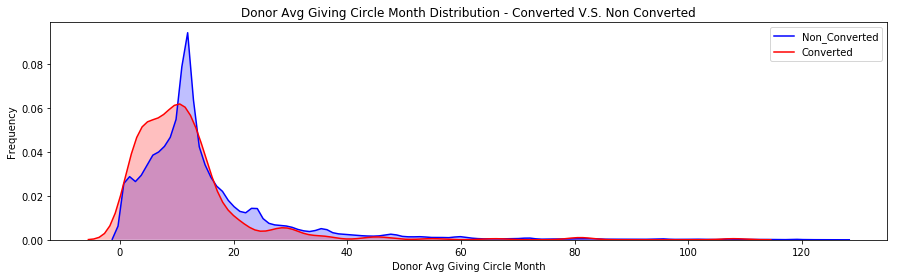

In [138]:
#KDEPlot: Kernel Density Estimate Plot#KDEPlot 
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(df.loc[(df['Convert'] == 0),'avg giving circle month'] , color='b',shade=True, label='Non_Converted')
ax=sns.kdeplot(df.loc[(df['Convert'] == 1),'avg giving circle month'] , color='r',shade=True, label='Converted')
ax.set(xlabel='Donor Avg Giving Circle Month', ylabel='Frequency')
plt.title('Donor Avg Giving Circle Month Distribution - Converted V.S. Non Converted')

Text(0.5,1,'Donor lapsed time Distribution - Converted V.S. Non Converted')

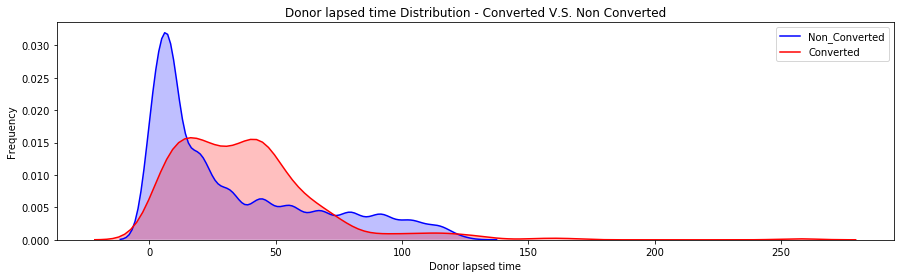

In [139]:
#KDEPlot: Kernel Density Estimate Plot#KDEPlot 
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(df.loc[(df['Convert'] == 0),'lapsed time'] , color='b',shade=True, label='Non_Converted')
ax=sns.kdeplot(df.loc[(df['Convert'] == 1),'lapsed time'] , color='r',shade=True, label='Converted')
ax.set(xlabel='Donor lapsed time', ylabel='Frequency')
plt.title('Donor lapsed time Distribution - Converted V.S. Non Converted')

Text(0.5,1,'Donor Age Distribution - Converted V.S. Non Converted')

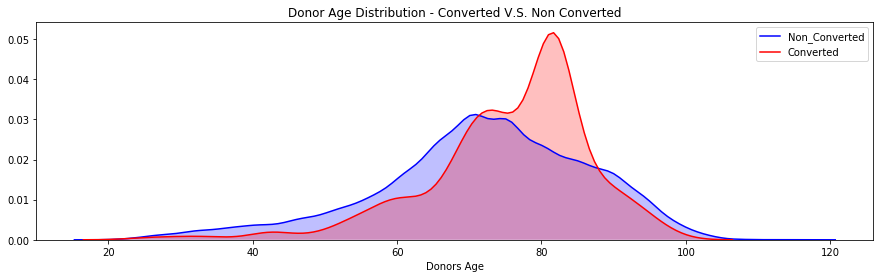

In [140]:
#KDEPlot: Kernel Density Estimate Plot#KDEPlot 
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(df.loc[(df['Convert'] == 0),'Imr_Age'] , color='b',shade=True, label='Non_Converted')
ax=sns.kdeplot(df.loc[(df['Convert'] == 1),'Imr_Age'] , color='r',shade=True, label='Converted')
ax.set(xlabel='Donors Age',label='Frequency')
plt.title('Donor Age Distribution - Converted V.S. Non Converted')

## EDA Three - Three Group Comparison

Text(0.5,1,'Donor life time length Distribution - living VS Deceased VS Non_Converted')

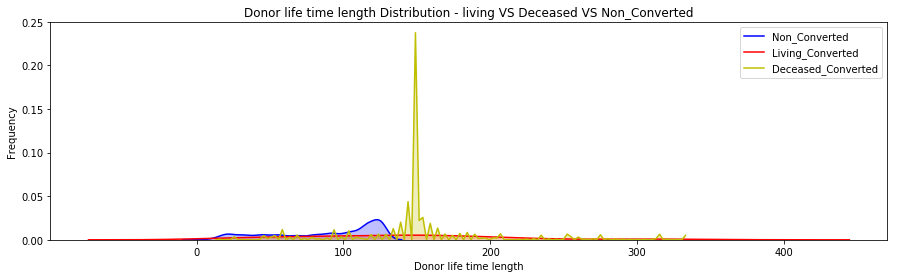

In [141]:
#KDEPlot: Kernel Density Estimate Plot#KDEPlot 
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(df.loc[(df['Convert'] == 0),'length'] , color='b',shade=True, label='Non_Converted')
ax=sns.kdeplot(LFJ_living_v2.loc[(LFJ_living_v2['Convert'] == 1),'length'] , color='r',shade=True, label='Living_Converted')
ax=sns.kdeplot(LFJ_deceased_v2.loc[(LFJ_deceased_v2['Convert'] == 1),'length'] , color='y',shade=True, label='Deceased_Converted')
ax.set(xlabel='Donor life time length', ylabel='Frequency')
plt.title('Donor life time length Distribution - living VS Deceased VS Non_Converted')

Text(0.5,1,'Donor Avg Giving Circle Month Distribution - living VS Deceased VS Non_Converted')

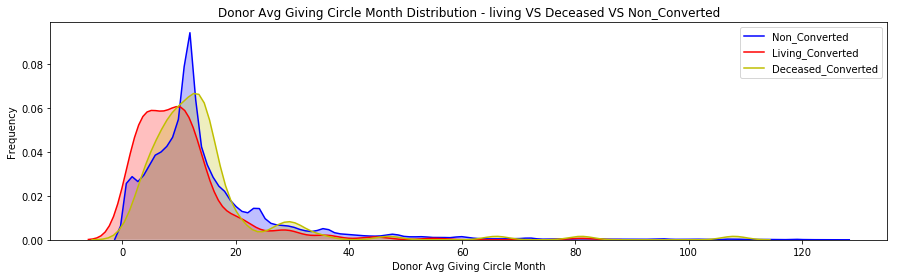

In [142]:
#KDEPlot: Kernel Density Estimate Plot#KDEPlot 
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(df.loc[(df['Convert'] == 0),'avg giving circle month'] , color='b',shade=True, label='Non_Converted')
ax=sns.kdeplot(LFJ_living_v2.loc[(LFJ_living_v2['Convert'] == 1),'avg giving circle month'] , color='r',shade=True, label='Living_Converted')
ax=sns.kdeplot(LFJ_deceased_v2.loc[(LFJ_deceased_v2['Convert'] == 1),'avg giving circle month'] , color='y',shade=True, label='Deceased_Converted')
ax.set(xlabel='Donor Avg Giving Circle Month', ylabel='Frequency')
plt.title('Donor Avg Giving Circle Month Distribution - living VS Deceased VS Non_Converted')

Text(0.5,1,'Donor lapsed time Distribution - living VS Deceased VS Non_Converted')

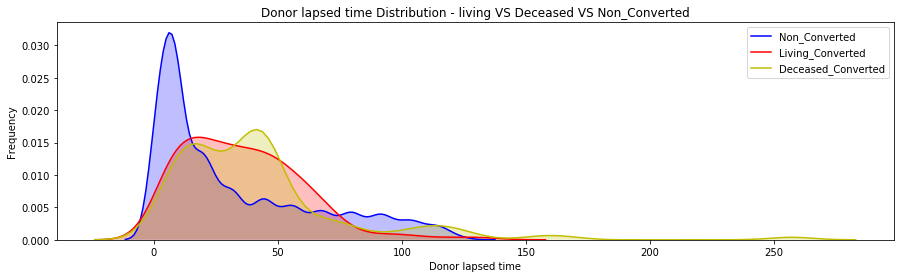

In [143]:
#KDEPlot: Kernel Density Estimate Plot#KDEPlot 
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(df.loc[(df['Convert'] == 0),'lapsed time'] , color='b',shade=True, label='Non_Converted')
ax=sns.kdeplot(LFJ_living_v2.loc[(LFJ_living_v2['Convert'] == 1),'lapsed time'] , color='r',shade=True, label='Living_Converted')
ax=sns.kdeplot(LFJ_deceased_v2.loc[(LFJ_deceased_v2['Convert'] == 1),'lapsed time'] , color='y',shade=True, label='Deceased_Converted')
ax.set(xlabel='Donor lapsed time', ylabel='Frequency')
plt.title('Donor lapsed time Distribution - living VS Deceased VS Non_Converted')

Text(0.5,1,'Donor Age Distribution - living VS Deceased VS Non_Converted')

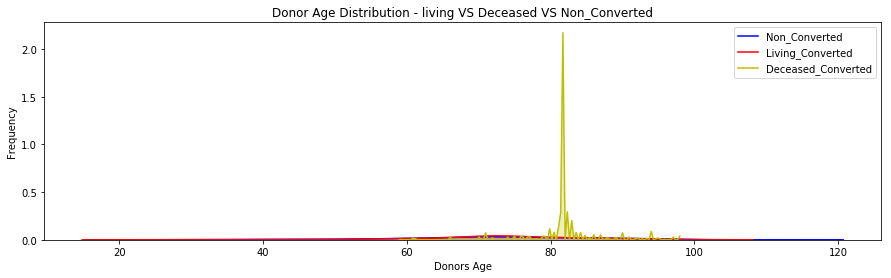

In [144]:
#KDEPlot: Kernel Density Estimate Plot#KDEPlot 
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(df.loc[(df['Convert'] == 0),'Imr_Age'] , color='b',shade=True, label='Non_Converted')
ax=sns.kdeplot(LFJ_living_v2.loc[(LFJ_living_v2['Convert'] == 1),'Imr_Age'] , color='r',shade=True, label='Living_Converted')
ax=sns.kdeplot(LFJ_deceased_v2.loc[(LFJ_deceased_v2['Convert'] == 1),'Imr_Age'] , color='y',shade=True, label='Deceased_Converted')
ax.set(xlabel='Donors Age', ylabel='Frequency')
plt.title('Donor Age Distribution - living VS Deceased VS Non_Converted')

## Class Imbalance

In [145]:
df.Convert.value_counts(1)

0    0.994084
1    0.005916
Name: Convert, dtype: float64

The converted group only contain 0.6% of donors. This dataset is super imbalanced. 

Text(0,0.5,'Count')

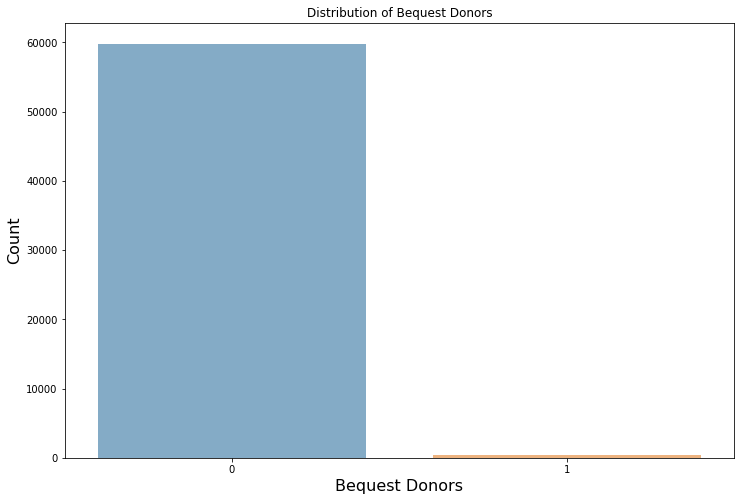

In [146]:
plt.figure(figsize=(12,8))
Converted_count = df['Convert'].value_counts()
sns.barplot(y=Converted_count.values, x=Converted_count.index, alpha=0.6)
plt.title('Distribution of Bequest Donors')
plt.xlabel('Bequest Donors', fontsize=16)
plt.ylabel('Count', fontsize=16)

## How to Treat Imbalanced Datasets

There are many ways of dealing with imblanced dataset. We applied the following resampling approaches: 
1. Oversampling -- SMOTE
2. Undersampling -- RandomUnderSampler
3. Downsampling

## Split Train/Test Set

Split data into a train and test set. We will fit our model with the train set and leave our test set for our last evaluation. 

In [147]:
cat_var = ['Appeal Description','PG donor']
num_var = ['Imr_Age','Total Amount of Gifts','avg giving circle month','lapsed time','length']
df=df[['Convert','Appeal Description','PG donor','Imr_Age','Total Amount of Gifts','avg giving circle month','lapsed time','length']]
df_new=pd.get_dummies(df,columns=['Appeal Description','PG donor'])

In [148]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score,recall_score, confusion_matrix,precision_recall_curve
from sklearn.preprocessing import StandardScaler
#Create X and y set

X=df_new.iloc[:,1:]
y=df_new.iloc[:,0]

#Define train and test
X_train,X_test,y_train, y_test = train_test_split(X,y,test_size=0.23,stratify=y)

stdsc = StandardScaler()
X_train=stdsc.fit_transform(X_train)
X_test=stdsc.transform(X_test)

## Resample Methods

Train a base logistic regression medel on the three types of samples to see which yields the best results:
1. Orginal Sample 
2. Upsampling Data
3. Downsampleing Data

![Image of Resampling](https://api.ning.com/files/vvHEZw33BGqEUW8aBYm4epYJWOfSeUBPVQAsgz7aWaNe0pmDBsjgggBxsyq*8VU1FdBshuTDdL2-bp2ALs0E-0kpCV5kVdwu/imbdata.png)

In [149]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

# Upsample minority class
X_train_u, y_train_u = resample(X_train[y_train == 1],
                                y_train[y_train == 1],
                                replace=True,
                                n_samples=X_train[y_train == 0].shape[0],
                                random_state=1)

X_train_u = np.concatenate((X_train[y_train == 0], X_train_u))
y_train_u = np.concatenate((y_train[y_train == 0], y_train_u))


# Upsample using SMOTE
sm = SMOTE(random_state=12, ratio ='minority')
x_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)


# Downsample majority class
X_train_d, y_train_d = resample(X_train[y_train == 0],
                                y_train[y_train == 0],
                                replace=True,
                                n_samples=X_train[y_train == 1].shape[0],
                                random_state=1)
X_train_d = np.concatenate((X_train[y_train == 1], X_train_d))
y_train_d = np.concatenate((y_train[y_train == 1], y_train_d))


print("Original shape:", X_train.shape, y_train.shape)
print("Upsampled shape:", X_train_u.shape, y_train_u.shape)
print ("SMOTE sample shape:", x_train_sm.shape, y_train_sm.shape)
print("Downsampled shape:", X_train_d.shape, y_train_d.shape)

Original shape: (46333, 15) (46333,)
Upsampled shape: (92118, 15) (92118,)
SMOTE sample shape: (92118, 15) (92118,)
Downsampled shape: (548, 15) (548,)


## Choose Which Sampling Technique to Use For Model

Train on Original, Upsampled, SMOTE, and Downsampled Data¶
Objective:Train our Logistic Regression Model to our original, upsampled, and downsampled data to see which performs best.

Results: 
1. Oiginal Sample: F1 Score: 32.3%
2. Upsample: F1 Score: 73.7%
3. SMOTE: F1 Score: 74.4%
4. Downsample: F1 Scores: 73.5% 

SMOTE gives us the best performance

## Upsample

Randomly resmple the minority class to create new data

## SMOTE

Use the nearest neighbors of the minority observations to create new synthetic data

## Downgrade

Remove some samples of the majority class

## Test Logistic Regression Performace

In [150]:
# Create the Original, Upsampled, and Downsampled training sets
methods_data = {"Original": (X_train, y_train),
                "Upsampled": (X_train_u, y_train_u),
                "SMOTE":(x_train_sm, y_train_sm),
                "Downsampled": (X_train_d, y_train_d)}

# Loop through each type of training sets and apply 10-Fold CV using Logistic Regression
# By default in cross_val_score StratifiedCV is used
for method in methods_data.keys():
    lr_results = cross_val_score(LogisticRegression(), methods_data[method][0], methods_data[method][1], cv=10, scoring='f1')
    print(f"The best F1 Score for {method} data:")
    print (lr_results.mean())
 
cross_val_score(LogisticRegression(class_weight='balanced'), X_train, y_train, cv=10, scoring='f1').mean()

The best F1 Score for Original data:
0.2403045892742778
The best F1 Score for Upsampled data:
0.7290815972694967
The best F1 Score for SMOTE data:
0.7297951804749518
The best F1 Score for Downsampled data:
0.7210625810038491


0.030861409725151206

## Machine Learning Model

In [151]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,7 mins 30 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.5
H2O cluster version age:,1 month
H2O cluster name:,H2O_from_python_Sen_Huo_lvexnu
H2O cluster total nodes:,1
H2O cluster free memory:,3.317 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


In [152]:
df=df[df['length']<300]

In [153]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(df)
h2o_df['Convert'] = h2o_df['Convert'].asfactor()
h2o_df['PG donor'] = h2o_df['PG donor'].asfactor()

h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,Convert,Appeal Description,PG donor,Imr_Age,Total Amount of Gifts,avg giving circle month,lapsed time,length
type,enum,enum,enum,real,real,real,real,real
mins,,,,20.0,0.0,1.0,0.0,3.0
mean,,,,71.9430805918274,126708.05883436163,15.170046841041627,32.49953500739501,87.87496299250665
maxs,,,,116.0,2371200000.0,126.0,257.0,298.0
sigma,,,,14.64343951743865,12136975.031524137,14.188347943598316,32.53664308364953,36.473445882283
zeros,,,,0,3,0,869,0
missing,0,0,0,0,0,0,0,0
0,0,event,0,68.0,8500.0,11.0,36.0,58.0
1,0,DM,0,90.0,360.0,7.0,16.0,63.0
2,0,event,0,69.0,200.0,114.0,2.0,116.0


In [154]:
# Split into 75% training and 25% test dataset# Split  
strat_split = h2o_df['Convert'].stratified_split(test_frac=0.25, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['Appeal Description', 'PG donor', 'Imr_Age', 'Total Amount of Gifts', 'avg giving circle month', 'lapsed time','length']
target = 'Convert'

In [155]:
# Build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=300, max_depth=10, categorical_encoding='auto',
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


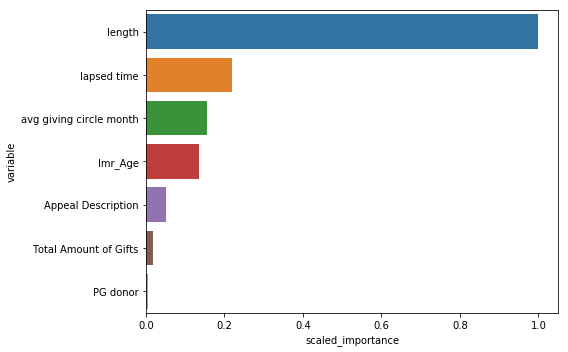

In [156]:
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.tight_layout()
plt.show()

In [157]:
# Make predictions
train_true = train.as_data_frame()['Convert'].values
test_true = test.as_data_frame()['Convert'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [158]:
#Confusion Matrix
model.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.005080881178702555: 


,0,1,Error,Rate
0,43752.0,1111.0,0.0248,(1111.0/44863.0)
1,404.0,44458.0,0.009,(404.0/44862.0)
Total,44156.0,45569.0,0.0169,(1515.0/89725.0)


In [159]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.01489).astype(int)))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     14954
          1       0.98      0.58      0.73        89

avg / total       1.00      1.00      1.00     15043



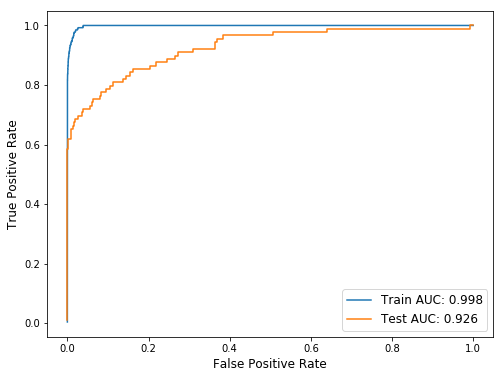

In [160]:
# ROC curves
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


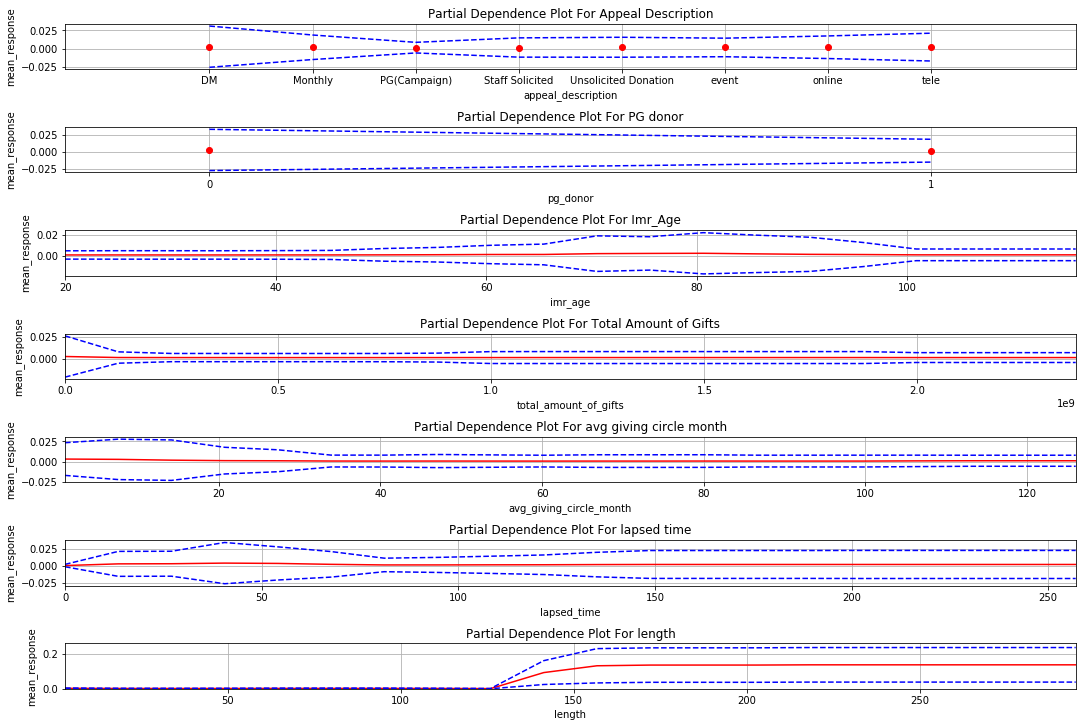

In [161]:
# Partial dependence plot
_ = model.partial_plot(train, cols=feature, figsize=(15, 10))

## What to Optimize
We want our mailing learn model to capture as much of the minority class as possible (converted group). Our objective is to catch all of the highly probable converted donors. 

## Conclusion










#### Binary Classification: converted vs non converted

#### Need for Application: 
In converted vs non converted project, rather than simply predicting whether an donor will leave a bequest within a certain time frame, we would much rather have an estimate of the probability that he/she will leave a bequest. We would rank donors by their probability of convert, then allocate resource/budget to the highest probability donors.

Consider a donor is given a PG package because HRW think the donor will leave a bequest in the future, but the donor actually will not. This is a false posive error. This mistake could be expensive, but is a good investment for relational growth. 

Compare this with the oppsite error, where HRW doesn't send the donor PG package and they do want to leave a bequest to non-profit organization. This is a False negative. This type of error is more detrimental because HWR may lose a huge amount of donation. 

Solution 1: 
* We can rank donors by their probability of convert, then allocate a limited budget to those highest probability donors. 

Solution 2: 
* Based on the modeling results, the most important features are length (donor lifetime) and lapsed time. We can share the feature importance and parital dependence results to HWR and they should follow the following critera to select donors. 

Top tier - select top tier donors based on following rules:
* donors with first gift date before 2008. 
* donors with lapsed time less than 50 OR donors with lapsed time greater than 130.
* donors average giving circle less than 20 month. 
* donors with age greater than 70.
* donors either came from DM. 









## Selection Bias

* One thing to note about this dateset is the super imbalenced class. A more healthy dataset should contain at least 2% converted donors. Although we applied resampling strategy and powerful machine learning algorithm, the selection bias might be large. 

* Another thing to note down is the missing values. Some records with missing age and deceased date in converted group, we have to impute a lot of missing values and we use those estimated value to build model. This will increase the selection bias as well. 